In [8]:
import os

import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np

In [9]:
def processing_image(img_path):
    # 讀取影像為 PIL 影像
    img = image.load_img(img_path, target_size=(224, 224))
    
    # 轉換 PIL 影像為 nparray
    x = image.img_to_array(img)
    
    # 加上一個 batch size，例如轉換 (224, 224, 3) 為 （1, 224, 224, 3) 
    x = np.expand_dims(x, axis=0)
    
    # 將 RBG 轉換為 BGR，並解減去各通道平均
    x = preprocess_input(x)
    
    return x

In [10]:
def gradcam(model, x):
    # 取得影像的分類類別
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])
    
    # 取得影像分類名稱
#     pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]
    
    # 預測分類的輸出向量
    pred_output = model.output[:, pred_class]
    
    # 最後一層 convolution layer 輸出的 feature map
    # ResNet 的最後一層 convolution layer
    last_conv_layer = model.get_layer('res5c_branch2c')
    
    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    
    # 求得針對每個 feature map 的梯度加總
    pooled_grads = K.sum(grads, axis=(0, 1, 2))
    
    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])

    # 計算 feature map 的 channel-wise 加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    return heatmap

In [11]:
def plot_heatmap(heatmap, img_path):
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    # 正規化
    heatmap /= np.max(heatmap)
    # 讀取影像
    img = cv2.imread(img_path)
    fig, ax = plt.subplots()
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))
    # 拉伸 heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    # 以 0.6 透明度繪製原始影像
    ax.imshow(im, alpha=0.6)
    # 以 0.4 透明度繪製熱力圖
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    
    plt.show()

In [ ]:
model = load_model("../../model_output/018_train.h5")

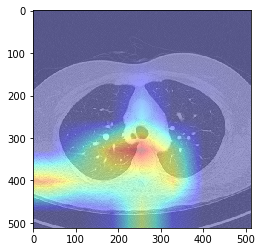

In [41]:
img_path = '../data_store/ALL_NORMAL/14/14_35.jpg'
img = processing_image(img_path)
heatmap = gradcam(model, img)
plot_heatmap(heatmap, img_path)

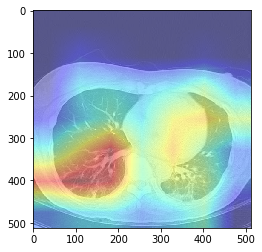

In [33]:
img_path = '../data_store/ALL_ILD/1/1_19.jpg'
img = processing_image(img_path)
heatmap = gradcam(model, img)
plot_heatmap(heatmap, img_path)

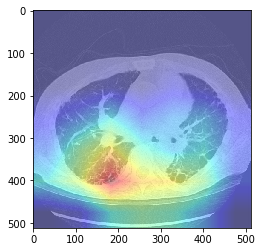

In [45]:
img_path = '../data_store/ALL_ILD/9/9_23.jpg'
img = processing_image(img_path)
heatmap = gradcam(model, img)
plot_heatmap(heatmap, img_path)